In [63]:
import pandas as pd
import numpy as np
import pandasql as ps
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pyhive import presto
from pymongo import MongoClient
import warnings
warnings.filterwarnings("ignore")

presto_conn = presto.connect(
    host='presto.processing.yoda.run',
    port=80,
    protocol='http',
    catalog='hive',
    username='mayank.jha@rapido.bike',
    # requests_kwargs=req_kw,
)

In [231]:
start_date = '2021-09-13'
end_date = '2021-09-19'
city = 'Kolkata'

# Fetch ratings and Rides for captains week on week

In [201]:
# Rides & Ratings

rides_query = """SELECT rider,
                    CAST(DATE_TRUNC('week',CAST(orderdate AS DATE)) as varchar) as order_week,
                    COUNT(DISTINCT(orderdate)) as wdays,
                    COUNT(DISTINCT(_id)) as rides,
                    -- avg(case when feedback_customerrating = -1 then 5 else feedback_customerrating end) as rating
                    coalesce(sum(case when feedback_customerrating = -1 then 0 else feedback_customerrating end)/(nullif(sum(case when feedback_customerrating = -1 then 0 else 1 end),0)*1.0),0) as rating
                    from legacy.orders
                    where orderdate >= '{sd}'
                    and orderdate <= '{ed}'
                    and status = 'dropped'
                    and spdfraud_flag != 1
                    and serviceobj_city = '{ct}'
                    group by 1, 2""".format(sd=start_date, ed= end_date, ct = city)

df_rides = pd.read_sql(rides_query, presto_conn)
df_rides.head()

,rider,order_week,wdays,rides,rating
0,5e2da03f329ce50e2cd26366,2021-09-13,2,8,4.0
1,5ce64a5f377155163c02cfe3,2021-09-13,5,63,0.0
2,5d3af33d9996733edb029878,2021-09-13,6,28,4.9
3,5f3aa17e0fbf963a4a530175,2021-09-13,1,1,0.0
4,6003fa592610d7294a08b9f4,2021-09-13,1,1,1.0


In [202]:
df_rides['week'] = pd.to_datetime(df_rides['order_week'])
df_rides['week'] = df_rides['week'].apply(lambda x : x.strftime('%Y-%V')[-2:]).apply(pd.to_numeric)
df_rides.drop(['order_week'],axis = 1, inplace=True)
df_rides.head()

,rider,wdays,rides,rating,week
0,5e2da03f329ce50e2cd26366,2,8,4.0,37
1,5ce64a5f377155163c02cfe3,5,63,0.0,37
2,5d3af33d9996733edb029878,6,28,4.9,37
3,5f3aa17e0fbf963a4a530175,1,1,0.0,37
4,6003fa592610d7294a08b9f4,1,1,1.0,37


In [203]:
# Commission and Discount

def get_commission_discount(start_date, end_date, city):
    print("fetching commission and discount for : ",start_date," to ", end_date)
    orders_query = """   select riderid,
        week,
        sum(cast(commission as double)) as commission,
        sum(cast(discount as double)) as discount
    from
        (select distinct riderid, 
                CAST(WEEK(DATE(date_parse(yyyymmdd,'%Y%m%d'))) as int) as week, 
                orderid, 
                orderslabdata_payoutcommission as commission, 
                orderslabdata_discount as discount
            from raw.mongodb_rapidopayroll_riderspaymentnew_immutable 
            where status = 'success' 
                and transactionType = 'orders' 
                and yyyymmdd between '{sd}' and '{ed}'
                and city = '{ct}'
        )
    group by 1,2              
               """.format(sd = start_date.replace('-',''), ed = end_date.replace('-',''), ct = city)


    df_cd = pd.read_sql(orders_query, presto_conn)
    
    print(" fetched commission and discount", len(df_cd))

    return df_cd

df_commission = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list : 
    commission = get_commission_discount(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'), city)
    x = pd.to_datetime(day).strftime('%Y-%V')
    commission['week'] = x[-2:]
    commission['week'] = commission['week'].apply(pd.to_numeric)
    df_commission = pd.concat([df_commission,commission])

df_commission.head()

fetching commission and discount for :  2021-09-13  to  2021-09-19
 fetched commission and discount 8076


,riderid,week,commission,discount
0,5f8d9a2204d6643ade59e22e,37,237.721,171.0
1,5e4f7eb9803af8af4217fd31,37,427.518,184.0
2,5e69179dd49cc69c0184b972,37,3.141,8.0
3,5de5e9a4d472d62e945ccd7d,37,112.150,26.0
4,5f5a631e9672ebe50f685027,37,60.433,0.0


In [204]:
final_data = df_rides.merge(df_commission, how = 'left', left_on = ['rider','week'], right_on = ['riderid','week'])
final_data.drop(['riderid'], axis = 1, inplace = True)
final_data.head()

,rider,wdays,rides,rating,week,commission,discount
0,5e2da03f329ce50e2cd26366,2,8,4.0,37,0.000,65.0
1,5ce64a5f377155163c02cfe3,5,63,0.0,37,0.000,0.0
2,5d3af33d9996733edb029878,6,28,4.9,37,282.203,104.0
3,5f3aa17e0fbf963a4a530175,1,1,0.0,37,0.000,0.0
4,6003fa592610d7294a08b9f4,1,1,1.0,37,16.290,11.0


# Fetch login hours for captains week on week

In [205]:
# Login hours

def get_login_hours(start_date, end_date, city):
    print("fetching Login hours for : ",start_date," to ", end_date)
    orders_query = """   SELECT 
        userid as rider, 
        --CAST(WEEK(DATE(date_parse(yyyymmdd,'%Y%m%d'))) as int) as week,
        --date_format(date_parse(yyyymmdd, '%Y%m%d'), '%Y-%m-%d') AS logindate, 
        cast(sum(duration) as double)/cast((60*60*1000) as double) as login_hours
        FROM hive.datasets.captain_login_hours
        WHERE yyyymmdd >= '{sd}' AND yyyymmdd <= '{ed}'
        AND status in ('2','3','6','7','8','10')
        AND userid in (SELECT captainId from datasets.captain_single_view WHERE upper(registeredcity) = upper('{ct}')  AND activationdate is not null)
        GROUP BY 1                
               """.format(sd = start_date.replace('-',''), ed = end_date.replace('-',''), ct = city)


    df_lh = pd.read_sql(orders_query, presto_conn)
    
    print(" fetched Login hours", len(df_lh))

    return df_lh

df_login_hours = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list : 
    login_hours = get_login_hours(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'), city)
    x = pd.to_datetime(day).strftime('%Y-%V')
    login_hours['week'] = x[-2:]
    login_hours['week'] = login_hours['week'].apply(pd.to_numeric)
    df_login_hours = pd.concat([df_login_hours,login_hours])

df_login_hours.head()

fetching Login hours for :  2021-09-13  to  2021-09-19
 fetched Login hours 14796


,rider,login_hours,week
0,5d616338a24c96105e2304fd,0.334688,37
1,5ca700fd194e920db0998ea4,0.031735,37
2,5de78dc939cbc02e909865f8,7.445114,37
3,6080e0e275dfce6f38df9719,4.898528,37
4,5ca11c978c352421ea058ac1,8.003311,37


In [206]:
final_data = final_data.merge(df_login_hours, how = 'left', left_on = ['rider','week'], right_on = ['rider','week'])
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours
0,5e2da03f329ce50e2cd26366,2,8,4.0,37,0.000,65.0,11.596820
1,5ce64a5f377155163c02cfe3,5,63,0.0,37,0.000,0.0,33.653192
2,5d3af33d9996733edb029878,6,28,4.9,37,282.203,104.0,20.536899
3,5f3aa17e0fbf963a4a530175,1,1,0.0,37,0.000,0.0,NaN
4,6003fa592610d7294a08b9f4,1,1,1.0,37,16.290,11.0,9.189037


# Fetch Earnings for captains week on week

In [207]:
# Earnings

def get_earnings():

    orders_query = """   
    select riderid, 
        week,
        sum(amount) as orders_earnings
    from
        (select distinct riderId as riderid,
                orderid,
                CAST(WEEK(DATE(date_parse(yyyymmdd,'%Y%m%d'))) as int) as week,
                cast(amount as double) as amount 
            from raw.mongodb_rapidopayroll_riderspaymentnew_immutable
            where yyyymmdd between '{sd}' and '{ed}'
                and city = '{ct}' 
                and transactionType = 'orders' 
                and status = 'success'
        )
    group by 1,2
               """.format(sd = start_date.replace('-',''), ed = end_date.replace('-',''), ct = city)
    df_orders_data = pd.read_sql(orders_query, presto_conn)
    return df_orders_data

df_earnings = get_earnings()
df_earnings.head()

,riderid,week,orders_earnings
0,5f494197f330bab97e0b48cc,37,559.75
1,5f2970ed4b3a15e698c5b7ca,37,4187.96
2,5daaca2452047954050edfc7,37,852.02
3,5d8b58d5a1f0a71c6046f858,37,1119.31
4,5c726c975e042733c9bd4544,37,766.97


In [208]:
final_data = final_data.merge(df_earnings, how = 'left', left_on = ['rider','week'], right_on = ['riderid','week'])
final_data.drop(['riderid'], axis = 1, inplace=True)
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings
0,5e2da03f329ce50e2cd26366,2,8,4.0,37,0.000,65.0,11.596820,903.58
1,5ce64a5f377155163c02cfe3,5,63,0.0,37,0.000,0.0,33.653192,2680.00
2,5d3af33d9996733edb029878,6,28,4.9,37,282.203,104.0,20.536899,1881.34
3,5f3aa17e0fbf963a4a530175,1,1,0.0,37,0.000,0.0,NaN,40.00
4,6003fa592610d7294a08b9f4,1,1,1.0,37,16.290,11.0,9.189037,108.60


# Fetch APR, CR for captains week on week

In [209]:
# APR and CR and OCARA

# Fetch the Cancel Rate Data

def get_pings(sdate, edate, city):

    dpr_query = """
                with orders 
    as 
    (
        SELECT
        *, 
        case when test_order_status='onTheWay' and order_status='customerCancelled' and cancel_reason = 'Taking longer than expected' and time_diff > fe_eta then 1 else 0 end as long_flag
        from 
        (
        SELECT 
        order_id,
        city_name, 
        captain_obj_mobile,
        captain_id, 
        case when array_distinct(array_agg(captain_id) over (partition by order_id order by updated_epoch)) is null then 0 else cardinality(array_distinct(array_agg(captain_id) over (partition by order_id order by updated_epoch))) - 1 end  as ping_captains1,
        DATE_FORMAT(FROM_UNIXTIME(ROUND(updated_epoch/ 1000), 'Asia/Kolkata'), '%Y-%m-%d %H:%i:%s')  as  ds,
        event_type, 
        lag(DATE_FORMAT(FROM_UNIXTIME(ROUND(updated_epoch/ 1000), 'Asia/Kolkata'), '%Y-%m-%d %H:%i:%s'))  over (partition by order_id order by updated_epoch) as test_ds,
        (updated_epoch -  lag(updated_epoch) over (partition by order_id order by updated_epoch))/1000 as time_diff,
        lag(order_status)  over (partition by order_id order by updated_epoch) as test_order_status,
        order_status, 
        cancel_reason,
        case when event_type = 'accepted' then 1 else 0 end accepted_flag,
        case when event_type = 'rider_cancelled' then 1 else 0 end rc_flag,
        case when event_type = 'rider_busy' then 1 else 0 end as rb_flag,
        case when event_type = 'rider_reject' then 1 else 0 end as  rj_flag,
        case when event_type = 'customer_cancelled' and cancel_reason IN ('Drop location denied', 'Vehicle / Safety issues', 'Asked to cancel & take offline ride', 'Asked to cancel', 'Captain Asking to pay extra' )  then 1 else 0 end as cc_flag, 
        case when event_type = 'dropped' then 1 else 0 end as  net_flag,
        case when event_type in ('rider_busy', 'rider_reject', 'accepted') then 1 else 0 end as total_pings,
        eta*60 as fe_eta
        from 
        orders.order_logs_immutable 
        where 1=1 
        and yyyymmdd >= '{sd}'
        and yyyymmdd <= '{ed}'
        and city_name = '{city}'
        )
    )



    --  Taking longer than expected where OTW ETA < time to cancel 

     ,customer_contact_captain 
    AS 
    (

    SELECT 
            * FROM 
            (
                SELECT eventprops_orderid,
                eventprops_screen ,
                eventProps_captainid,
                eventprops_orderid as customer_contact_captain_id ,
                ROW_NUMBER() OVER (PARTITION BY eventprops_orderid  ORDER BY epoch desc) AS Rank_
                FROM  raw.clevertap_customer_callrider 
                where 
                1=1           
                and
                length(eventprops_orderid)>=2
                -- AND 
                -- eventProps_orderType='B2C'
                AND 
                raw.clevertap_customer_callrider.yyyymmdd >= '{sd}'
                AND raw.clevertap_customer_callrider.yyyymmdd <= '{ed}'
                ORDER BY 1

            )
    WHERE Rank_=1

    )


    ,captain_contact_customer 
    AS 
    (

    SELECT 
            * FROM 
            (
                SELECT eventprops_orderid, 
                eventprops_context ,
                eventprops_orderid as captain_contact_customer_id,
                profile_identity,
                profile_phone, 
                ROW_NUMBER() OVER (PARTITION BY eventprops_orderid  ORDER BY epoch desc) AS Rank_
                FROM  raw.clevertap_captain_callcustomer 
                where 
                1=1           
                and
                length(eventprops_orderid)>=2
                AND
                raw.clevertap_captain_callcustomer.yyyymmdd >= '{sd}'
                AND raw.clevertap_captain_callcustomer.yyyymmdd <= '{ed}'
                ORDER BY 1
            )
    WHERE Rank_=1

    )


    ,captain_info
    AS 
    (

            select 
            orders.city_name, 
            orders.captain_id, 
            sum(case when  (cc_flag=1 and (customer_contact_captain.customer_contact_captain_id is not null or captain_contact_customer.captain_contact_customer_id is not null) 
                and (eventProps_captainid is not null or captain_contact_customer.profile_identity is not null))  then 1 else 0 end) as cc_flag_call_pings, 
            sum(net_flag) as Net, 
            sum(accepted_flag) as Accepted_pings,
            sum(rc_flag) RiderCancelled_pings , 
            sum(rb_flag) as RiderBusy_pings, 
            sum(rj_flag) as RiderReject_Pings, 
            sum(total_pings) as total_pings, 
            sum(long_flag) as long_flag
            FROM 
            orders left join customer_contact_captain on customer_contact_captain.customer_contact_captain_id = orders.order_id 
                                                    and customer_contact_captain.eventProps_captainid = orders.captain_id

                  left join captain_contact_customer on captain_contact_customer.captain_contact_customer_id = orders.order_id 
                                                     and substr(captain_contact_customer.profile_phone,-10) = orders.captain_obj_mobile
            where 1=1 
                    and captain_id is not null
            group by 1,2
            -- and orders.cancel_reason != 'Not able to swipe Arrived'
    ) 


    , city_aggr
    as
    (
    select
    city_name, 
    approx_percentile(dpr,(1.00*100)/100) as median_city, 
    (coalesce(TRY((sum(Net)*1.00)/(sum(net) + sum(cc_flag_call_pings) + sum(RiderCancelled_pings) + sum(RiderBusy_pings) + sum(long_flag) + sum(RiderReject_Pings))),0)) as dpr_city , 
    (coalesce(TRY((sum(Net)*1.00)/(sum(total_pings))),0)) as dpr_city_old  

    from
        (
            select 
            city_name,
            captain_info.Net, 
            captain_info.Accepted_pings,
            captain_info.cc_flag_call_pings,
            captain_info.RiderCancelled_pings,
            captain_info.RiderBusy_pings, 
            captain_info.RiderReject_Pings, 
            captain_info.total_pings,
            captain_info.long_flag,
            try(coalesce((((captain_info.Net)*1.00)/((captain_info.net) + (captain_info.cc_flag_call_pings) + (captain_info.long_flag) + (captain_info.RiderCancelled_pings) + (captain_info.RiderBusy_pings) + (captain_info.RiderReject_Pings))),0)) as dpr
            FROM 
            captain_info 
        )
        group by 1 

    )

    -- select * from orders where long_flag=1 

    SELECT 
    captain_info.city_name AS "City",
    captain_info.captain_id, 

    --captain_info.total_pings AS "Total Pings",
    captain_info.Accepted_pings AS "Accepted Pings",
    --captain_info.Net AS "Net", 

    captain_info.cc_flag_call_pings+captain_info.long_flag AS "Captain-induced CC Pings" ,
    captain_info.RiderCancelled_pings AS "Rider Cancelled Pings",
    captain_info.RiderBusy_pings AS "Rider Busy Pings", 
    captain_info.RiderReject_Pings AS "Rider Rejected Pings" 


    --coalesce(TRY((captain_info.Accepted_pings*1.00)/captain_info.total_pings),0) AS "APR", 
    --coalesce(TRY(((captain_info.cc_flag_call_pings+captain_info.long_flag+captain_info.RiderCancelled_pings)*1.00)/(captain_info.cc_flag_call_pings+captain_info.long_flag+captain_info.net+captain_info.RiderCancelled_pings)),0) AS "Cancellation Rate", 
    --(coalesce(TRY(((captain_info.Net)*1.00)/((captain_info.net) + (captain_info.cc_flag_call_pings) + (captain_info.RiderCancelled_pings) + (captain_info.long_flag) + (captain_info.RiderBusy_pings) + (captain_info.RiderReject_Pings))),0)) as "True DPR(Captain)", 
    --(coalesce(TRY(((captain_info.Net)*1.00)/(captain_info.total_pings)),0)) as "Old DPR(Captain)", 



    --dpr_city as "True DPR(City)",
    --city_aggr.dpr_city_old as "Old DPR(City)",
    --city_aggr.median_city as "Nth_percentile City"
    FROM 
    captain_info 
    JOIN city_aggr on city_aggr.city_name = captain_info.city_name 
    where 1=1 
    and median_city >= (coalesce(TRY(((captain_info.Net)*1.00)/((captain_info.net) + (captain_info.cc_flag_call_pings) + (captain_info.RiderCancelled_pings) + (captain_info.RiderBusy_pings) + (captain_info.RiderReject_Pings))),0))

    order by captain_info.city_name,total_pings desc

    -- select * FROM city_agg""".format(sd = sdate, ed = edate, city = city)

    #print(dpr_query)
    df_temp = pd.read_sql(dpr_query, presto_conn)
    return df_temp

In [210]:
date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]

date_list = [x.strftime('%Y-%m-%d') for x in date_list]
date_list

['2021-09-13']

In [211]:
df_dpr = pd.DataFrame()

for day in date_list : 

    df_temp = get_pings(day.replace('-',''), (pd.to_datetime(day)+timedelta(6)).strftime('%Y%m%d'), city)
    df_temp['week'] = pd.to_datetime(day).strftime('%Y-%V')
    df_dpr = pd.concat([df_dpr,df_temp])

In [212]:
df_dpr['week'] = df_dpr['week'].apply(lambda x : x[-2:]).apply(pd.to_numeric)

In [213]:
df_dpr['cancel'] = (df_dpr['Captain-induced CC Pings']+df_dpr['Rider Cancelled Pings'])/df_dpr['Accepted Pings'] 
df_dpr['cancel'] = df_dpr['cancel'].fillna(0)

#final_data['total_pings'] = final_data['accepted_pings']+final_data['rider_busy_pings']+final_data['rider_rejected_pings']
df_dpr['APR'] = df_dpr['Accepted Pings']/(df_dpr['Accepted Pings']+df_dpr['Rider Busy Pings']+df_dpr['Rider Rejected Pings'])
df_dpr['APR'] = df_dpr['APR'].fillna(0)

df_dpr.head()

,City,captain_id,Accepted Pings,Captain-induced CC Pings,Rider Cancelled Pings,Rider Busy Pings,Rider Rejected Pings,week,cancel,APR
0,Kolkata,5c3c63c54a267149c76f8268,88,0,0,58,1434,37,0.000000,0.055696
1,Kolkata,6023a4f79072144c648ee893,43,0,0,740,261,37,0.000000,0.041188
2,Kolkata,606f01481588c7a4d273fd9d,63,0,0,899,0,37,0.000000,0.065489
3,Kolkata,5c17ef578102d76476ff9d4b,71,0,6,42,837,37,0.084507,0.074737
4,Kolkata,5c35a1f64a267149c76a528d,24,3,5,105,819,37,0.333333,0.025316


In [214]:
final_data = final_data.merge(df_dpr[['captain_id','week','APR','cancel']], how = 'left', left_on = ['rider','week'], right_on = ['captain_id','week'])
final_data.drop(['captain_id'], axis = 1, inplace=True)
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel
0,5e2da03f329ce50e2cd26366,2,8,4.0,37,0.000,65.0,11.596820,903.58,0.190476,0.150000
1,5ce64a5f377155163c02cfe3,5,63,0.0,37,0.000,0.0,33.653192,2680.00,0.212308,0.057971
2,5d3af33d9996733edb029878,6,28,4.9,37,282.203,104.0,20.536899,1881.34,0.448276,0.134615
3,5f3aa17e0fbf963a4a530175,1,1,0.0,37,0.000,0.0,NaN,40.00,0.111111,0.000000
4,6003fa592610d7294a08b9f4,1,1,1.0,37,16.290,11.0,9.189037,108.60,0.189873,0.333333


# Fetch OCARA for captains week on week

In [215]:
# Calculate OCARA

ocara_query = """select 
    rider,
    CAST(DATE_TRUNC('week',CAST(orderdate AS DATE)) as varchar) as order_week,
    round(100 * (cast(count(case when ((status != 'dropped') and (status != 'expired') and (cancelreason != 'order cancelled before rider accepted')) then 1 end) as double) / count(_id)), 2) as ocara
from legacy.orders
where 
    orderdate between '{sd}' and '{ed}'
    and serviceobj_city = '{ct}'
group by 1,2 """.format(sd = start_date, ed = end_date, ct = city)

df_ocara = pd.read_sql(ocara_query, presto_conn)
print(len(df_ocara))

9350


In [216]:
df_ocara['week'] = pd.to_datetime(df_ocara['order_week'])
df_ocara['week'] = df_ocara['week'].apply(lambda x : x.strftime('%Y-%V')[-2:]).apply(pd.to_numeric)
df_ocara.drop(['order_week'],axis = 1, inplace=True)
df_ocara.head()

,rider,ocara,week
0,5d19deb0668011467e275b7b,42.11,37
1,5c1f31613f491d0a6e60d10c,58.06,37
2,5d9fffbaa1f0a71c60632063,5.56,37
3,5d014079ca6e2921117c1baa,16.67,37
4,60d0cdeb0546892125dcedb8,13.51,37


In [217]:
final_data = final_data.merge(df_ocara, how = 'left', left_on = ['rider','week'], right_on = ['rider','week'])
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel,ocara
0,5e2da03f329ce50e2cd26366,2,8,4.0,37,0.000,65.0,11.596820,903.58,0.190476,0.150000,52.94
1,5ce64a5f377155163c02cfe3,5,63,0.0,37,0.000,0.0,33.653192,2680.00,0.212308,0.057971,3.08
2,5d3af33d9996733edb029878,6,28,4.9,37,282.203,104.0,20.536899,1881.34,0.448276,0.134615,33.33
3,5f3aa17e0fbf963a4a530175,1,1,0.0,37,0.000,0.0,NaN,40.00,0.111111,0.000000,0.00
4,6003fa592610d7294a08b9f4,1,1,1.0,37,16.290,11.0,9.189037,108.60,0.189873,0.333333,88.89


In [218]:
# Find the incentive eligible and incentive achieved

def get_incentive_eligible(start_date, end_date, city):
    
    print("fetching eligible incentive for : ",start_date," to ", end_date)

    incentive_eligible = """with incentive as 
            (select distinct _id as incentive_id
                from hive.raw.mongodb_rapidopayroll_incentives_immutable
                where json_array_contains(cities, '{ct}')
                    and startDate between '{sd}' and '{ed}'
                    and endDate between '{sd}' and '{ed}'
            ),
daily_incentive as
            (select riderid,
                    sum(daily_incentive_achieved) as daily_incentive
                from
                    (select distinct riderid,
                            yyyymmdd,
                            tincentiveIdl,
                            subIncentiveId,
                            incentivestage,
                            cast(amount as double) as daily_incentive_achieved
                        from raw.mongodb_rapidopayroll_riderspaymentnew_immutable
                        where incentivetype = 'Daily' 
                            and status = 'success' 
                            and yyyymmdd between '{sd1}' and '{ed1}'
                            and city = '{ct}'
                    ) x
                    join incentive as i
                        on x.tincentiveIdl = i.incentive_id
                group by 1
            ),
weekly_incentive as
            (select riderid,
                    sum(weekly_incentive_achieved) as weekly_incentive
                from
                    (select distinct riderid,
                            yyyymmdd,
                            tincentiveIdl,
                            subIncentiveId,
                            incentivestage,
                            cast(amount as double) as weekly_incentive_achieved
                        from raw.mongodb_rapidopayroll_riderspaymentnew_immutable
                        where incentivetype = 'Weekly Fixed' 
                            and status = 'success' 
                            and yyyymmdd between '{sd1}' and '{ed1}'
                            and city = '{ct}'
                    ) x
                    join incentive as i
                        on x.tincentiveIdl = i.incentive_id
                group by 1
            )
            select coalesce(d.riderid, w.riderid) as riderid,
                d.daily_incentive,
                w.weekly_incentive
            from daily_incentive as d
                full outer join 
                    weekly_incentive as w
                        on d.riderid = w.riderid                    
               """.format(sd = start_date, ed = end_date, sd1 = start_date.replace('-',''), ed1 = end_date.replace('-',''),ct = city)
    
    #print(incentive_eligible)

    df_incentive_eligible = pd.read_sql(incentive_eligible, presto_conn)
    
    print(" fetching incentive eligible captains", len(df_incentive_eligible))

    return df_incentive_eligible

df_incentive_eligible = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list : 
    incentive_eligible = get_incentive_eligible(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'), city)
    x = pd.to_datetime(day).strftime('%Y-%V')
    incentive_eligible['week'] = x[-2:]
    incentive_eligible['week'] = incentive_eligible['week'].apply(pd.to_numeric)
    df_incentive_eligible = pd.concat([df_incentive_eligible,incentive_eligible])

df_incentive_eligible.head()
df_incentive_eligible.to_csv('subscription_incentive_Kolkata.csv', index = False)

fetching eligible incentive for :  2021-09-13  to  2021-09-19
 fetching incentive eligible captains 3370


In [219]:
final_data = final_data.merge(df_incentive_eligible[['riderid','daily_incentive','weekly_incentive','week']], how = 'left', left_on = ['rider','week'], right_on = ['riderid','week'])
final_data.drop(['riderid'], axis = 1, inplace=True)
final_data.fillna(0, inplace=True)
final_data['total_incentive'] = final_data['daily_incentive'] + final_data['weekly_incentive']
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel,ocara,daily_incentive,weekly_incentive,total_incentive
0,5e2da03f329ce50e2cd26366,2,8,4.0,37,0.000,65.0,11.596820,903.58,0.190476,0.150000,52.94,0.0,0,0.0
1,5ce64a5f377155163c02cfe3,5,63,0.0,37,0.000,0.0,33.653192,2680.00,0.212308,0.057971,3.08,348.0,0,348.0
2,5d3af33d9996733edb029878,6,28,4.9,37,282.203,104.0,20.536899,1881.34,0.448276,0.134615,33.33,0.0,0,0.0
3,5f3aa17e0fbf963a4a530175,1,1,0.0,37,0.000,0.0,0.000000,40.00,0.111111,0.000000,0.00,10.0,0,10.0
4,6003fa592610d7294a08b9f4,1,1,1.0,37,16.290,11.0,9.189037,108.60,0.189873,0.333333,88.89,0.0,0,0.0


# Fetch LTR

In [220]:
date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 6]

date_list = [x.strftime('%Y-%m-%d') for x in date_list]
date_list

['2021-09-19']

In [221]:
# Captain LTR calculation

def get_LTR(dt, city):
    
    captain_ltr_query = """SELECT  captainid, day, sum(lifetimenetrides) as ltr
        from 
        datasets_internal.captain_servicedetail_ridebehavior_immutable_v1 
        WHERE 
        day in (date '{day}')
        and lastridecity = '{ct}'
        group by 1, 2""".format( day = dt, ct = city)
    
    df_temp = pd.read_sql(captain_ltr_query, presto_conn)
    
    print(" fetching LTR ", len(df_temp))

    return df_temp

captain_ltr = pd.DataFrame()

for day in date_list : 

    df_LTR = get_LTR(day, city)
    captain_ltr = pd.concat([captain_ltr,df_LTR])

captain_ltr.head()

 fetching LTR  77403


,captainid,day,ltr
0,5d41a56215e40f18eabfebdb,2021-09-19,34
1,5df0f26dbe73542b52da2983,2021-09-19,1
2,5c812d878c352421eade5178,2021-09-19,5
3,5bb5dd337e7bc30a38385424,2021-09-19,469
4,5d00b4154b2c3775815a5be9,2021-09-19,344


In [222]:
captain_ltr['week'] = pd.to_datetime(captain_ltr['day'])
captain_ltr['week'] = captain_ltr['week'].apply(lambda x : x.strftime('%Y-%V')[-2:]).apply(pd.to_numeric)
captain_ltr.drop(['day'],axis = 1, inplace=True)
captain_ltr.head()

,captainid,ltr,week
0,5d41a56215e40f18eabfebdb,34,37
1,5df0f26dbe73542b52da2983,1,37
2,5c812d878c352421eade5178,5,37
3,5bb5dd337e7bc30a38385424,469,37
4,5d00b4154b2c3775815a5be9,344,37


In [223]:
final_data = final_data.merge(captain_ltr, how = 'left', left_on = ['rider','week'], right_on = ['captainid','week'])
final_data.drop(['captainid'], axis = 1, inplace=True)
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel,ocara,daily_incentive,weekly_incentive,total_incentive,ltr
0,5e2da03f329ce50e2cd26366,2,8,4.0,37,0.000,65.0,11.596820,903.58,0.190476,0.150000,52.94,0.0,0,0.0,640
1,5ce64a5f377155163c02cfe3,5,63,0.0,37,0.000,0.0,33.653192,2680.00,0.212308,0.057971,3.08,348.0,0,348.0,382
2,5d3af33d9996733edb029878,6,28,4.9,37,282.203,104.0,20.536899,1881.34,0.448276,0.134615,33.33,0.0,0,0.0,516
3,5f3aa17e0fbf963a4a530175,1,1,0.0,37,0.000,0.0,0.000000,40.00,0.111111,0.000000,0.00,10.0,0,10.0,167
4,6003fa592610d7294a08b9f4,1,1,1.0,37,16.290,11.0,9.189037,108.60,0.189873,0.333333,88.89,0.0,0,0.0,112


In [248]:
df_config = pd.DataFrame(columns=['priority','ltr','rides','rating','cancel'])
df_config = df_config.append(pd.DataFrame([[1,0,0,0,1]],columns=df_config.columns))
df_config = df_config.append(pd.DataFrame([[2,10,10,0.4,0.2]],columns=df_config.columns))
df_config = df_config.append(pd.DataFrame([[3,75,15,0.5,0.15]],columns=df_config.columns))
df_config = df_config.append(pd.DataFrame([[4,120,29,0.6,0.1]],columns=df_config.columns))
df_config

,priority,ltr,rides,rating,cancel
0,1,0,0,0,1
0,2,10,10,0.4,0.2
0,3,75,15,0.5,0.15
0,4,120,29,0.6,0.1


In [249]:
### Including all parameters :


data_sql_query = ps.sqldf("select lt.*, ft.priority from final_data lt left join df_config ft on lt.ltr >= ft.ltr and lt.rides >= ft.rides and lt.rating >= ft.rating and lt.cancel <= ft.cancel")

#max_priority = data_sql_query[data_sql_query['priority'] == data_sql_query['priority'].max()]

df_priority = data_sql_query.groupby(['rider','week']).agg({'priority':'max'}).reset_index()

In [250]:
final_data = final_data.merge(df_priority,how='left',left_on = ['rider','week'],right_on=['rider','week'])
final_data.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel,ocara,daily_incentive,weekly_incentive,total_incentive,ltr,priority
0,5cbb19613d65ca5e255e73e4,6,87,5.0,33,21.765,18.0,49.193174,3505.11,0.146084,0.020619,8.42,146.0,NaN,NaN,354.0,4.0
1,5e3fbb49b68cddddcbc7316a,2,6,5.0,35,70.514,30.0,7.815320,470.09,0.411765,0.285714,41.67,NaN,NaN,NaN,184.0,1.0
2,5cf0ddfc377155163c0be9de,5,30,0.0,34,0.000,0.0,25.729478,1230.00,0.206452,0.000000,6.25,191.0,NaN,NaN,772.0,1.0
3,5de69df5d472d62e945dec3b,4,23,0.0,33,0.000,0.0,11.602766,920.00,0.140244,0.000000,0.00,61.0,NaN,NaN,64.0,1.0
4,5f65e5b0cdf454745d8c369c,5,14,4.5,35,124.153,37.0,19.176682,827.68,0.820000,0.317073,48.39,NaN,120.0,NaN,92.0,1.0


In [227]:
final_data.to_csv('subscription_data_Kolkata.csv', index=False)

In [64]:
final_data = pd.read_csv('subscription_data_Kolkata.csv')

In [233]:
final_data['week'].unique()

array([33, 35, 34, 32, 30, 31, 36, 37])

In [69]:
final_data = final_data.merge(df_captains, how = 'inner', left_on = 'rider', right_on = 'rider')

KeyError: 'rider'

# Test Data preparation

In [34]:
w30 = pd.read_csv('Kolkata Week30.csv')
w31 = pd.read_csv('Kolkata Week31.csv')
w32 = pd.read_csv('Kolkata Week32.csv')
w33 = pd.read_csv('Kolkata Week33.csv')
w34 = pd.read_csv('Kolkata Week34.csv')
w35 = pd.read_csv('Kolkata Week35.csv')
w36 = pd.read_csv('Kolkata Week36.csv')
#w37 = pd.read_csv('Kolkata Week37.csv')

In [35]:
df_test = pd.concat([w30,w31,w32,w33,w34,w35,w36], axis=0)

In [36]:
df_test['mobile'] = df_test['mobile'].astype(str)

In [473]:
level_query = """select mobilenumber, captainid from datasets.captain_single_view where upper(registeredcity) = upper('{ct}') """.format(ct=city)

df_captains = pd.read_sql(level_query, presto_conn)
#df_captains['mobilenumber'] = df_captains['mobilenumber'].apply(pd.to_numeric)
print(len(df_captains))

260481


In [65]:
df_captains = pd.read_csv('mobile_number.csv')

In [38]:
df_test = df_test.merge(df_captains, how = 'left', left_on = 'mobile', right_on = 'mobilenumber')
df_test.drop(['mobilenumber'], axis = 1, inplace=True)
df_test.head()

,mobile,week,captainid
0,9007097334,30,5defd3691471f12b2a8efd6d
1,8013806931,30,5c978deeb50ab0456be354d4
2,7278299775,30,5cab76f7194e920db09b95a1
3,9163838443,30,5fbe0aae90d779a35bbe5b77
4,9674718929,30,5c36debcd8a7ad6ca4fb9200


In [39]:
df_test = df_test.merge(final_data, how = 'left', left_on = ['captainid','week'], right_on = ['rider','week'])
df_test.drop(['rider'], axis = 1, inplace=True)
df_test.head()

,mobile,week,captainid,wdays,rides,rating,commission,discount,login_hours,orders_earnings,APR,cancel,ocara,daily_incentive,weekly_incentive,total_incentive,ltr
0,9007097334,30,5defd3691471f12b2a8efd6d,6.0,44.0,5.0,0.000,186.0,36.434082,3257.05,0.909091,0.100000,33.82,296.0,200.0,496.0,3290.0
1,8013806931,30,5c978deeb50ab0456be354d4,5.0,37.0,4.1,380.385,67.0,30.010688,2570.90,0.942029,0.092308,35.09,216.0,0.0,216.0,1395.0
2,7278299775,30,5cab76f7194e920db09b95a1,1.0,4.0,5.0,61.335,0.0,3.609866,408.90,1.000000,0.142857,33.33,30.0,0.0,30.0,388.0
3,9163838443,30,5fbe0aae90d779a35bbe5b77,3.0,15.0,3.7,177.954,48.0,14.438729,1186.35,0.651163,0.285714,37.50,70.0,0.0,70.0,128.0
4,9674718929,30,5c36debcd8a7ad6ca4fb9200,6.0,31.0,4.7,0.000,60.0,21.107261,1755.83,0.583333,0.119048,15.79,264.0,206.0,470.0,3906.0


In [40]:
df_test['interested'] = 'Yes'
df_test['resubscribed'] = ''

In [41]:
for index, row in df_test.iterrows():
    commission = (0 if np.isnan(row['commission']) else row['commission'])
    discount = (0 if np.isnan(row['discount']) else row['discount'])
    total_incentive = (0 if np.isnan(row['total_incentive']) else row['total_incentive'])
    if row['interested'] == 'Yes':
        df_test.at[index,'cm'] = 120 - total_incentive
        df_test.at[index,'cm1'] = (120 - total_incentive) - discount
    else:
        df_test.at[index,'cm'] = commission - total_incentive
        df_test.at[index,'cm1'] = (commission - total_incentive) - discount
df_test.head()        

,mobile,week,captainid,wdays,rides,rating,commission,discount,login_hours,orders_earnings,...,cancel,ocara,daily_incentive,weekly_incentive,total_incentive,ltr,interested,resubscribed,cm,cm1
0,9007097334,30,5defd3691471f12b2a8efd6d,6.0,44.0,5.0,0.000,186.0,36.434082,3257.05,...,0.100000,33.82,296.0,200.0,496.0,3290.0,Yes,,-376.0,-562.0
1,8013806931,30,5c978deeb50ab0456be354d4,5.0,37.0,4.1,380.385,67.0,30.010688,2570.90,...,0.092308,35.09,216.0,0.0,216.0,1395.0,Yes,,-96.0,-163.0
2,7278299775,30,5cab76f7194e920db09b95a1,1.0,4.0,5.0,61.335,0.0,3.609866,408.90,...,0.142857,33.33,30.0,0.0,30.0,388.0,Yes,,90.0,90.0
3,9163838443,30,5fbe0aae90d779a35bbe5b77,3.0,15.0,3.7,177.954,48.0,14.438729,1186.35,...,0.285714,37.50,70.0,0.0,70.0,128.0,Yes,,50.0,2.0
4,9674718929,30,5c36debcd8a7ad6ca4fb9200,6.0,31.0,4.7,0.000,60.0,21.107261,1755.83,...,0.119048,15.79,264.0,206.0,470.0,3906.0,Yes,,-350.0,-410.0


In [42]:
df_indicator = pd.DataFrame()
for w in np.sort(df_test['week'].unique()):
    df_temp = df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')][['captainid','week']]
    df_previous = df_test[(df_test['week'] < w) & (df_test['interested'] == 'Yes')]['captainid']
    df_previous.drop_duplicates(keep='first',inplace=True)
    df_temp = df_temp.merge(df_previous, how = 'inner', on = 'captainid')
    df_indicator = pd.concat([df_indicator, df_temp])

df_test = df_test.merge(df_indicator, how = 'left', on = ['captainid','week'], indicator = True)
df_test['resubscribed'] = df_test.apply(lambda x : 'Yes' if x['_merge'] == 'both' else '', axis=1)
df_test.drop(['_merge'],axis = 1, inplace=True)

In [43]:
df_test['roi'] = (df_test['orders_earnings']*0.2 - 120)*100.0 / 120

In [480]:
df_test.to_csv('Kolkata Subscription Data Week 30 to Week 35.csv')

# Control Group Data Preparation

In [44]:
df_control = final_data.copy()
df_control = df_control.merge(df_test[['captainid','week']], left_on=['rider', 'week'],right_on = ['captainid', 'week'], how='left', indicator=True)
df_control = df_control[df_control['_merge']=='left_only']
df_control.drop(['captainid','_merge'], axis = 1, inplace=True)
df_control.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel,ocara,daily_incentive,weekly_incentive,total_incentive,ltr
0,5cbb19613d65ca5e255e73e4,6,87,5.0,33,21.765,18.0,49.193174,3505.11,0.146084,0.020619,8.42,146.0,0.0,146.0,354.0
1,5e3fbb49b68cddddcbc7316a,2,6,5.0,35,70.514,30.0,7.815320,470.09,0.411765,0.285714,41.67,0.0,0.0,0.0,184.0
2,5cf0ddfc377155163c0be9de,5,30,0.0,34,0.000,0.0,25.729478,1230.00,0.206452,0.000000,6.25,191.0,0.0,191.0,772.0
3,5de69df5d472d62e945dec3b,4,23,0.0,33,0.000,0.0,11.602766,920.00,0.140244,0.000000,0.00,61.0,0.0,61.0,64.0
4,5f65e5b0cdf454745d8c369c,5,14,4.5,35,124.153,37.0,19.176682,827.68,0.820000,0.317073,48.39,0.0,120.0,120.0,92.0


In [45]:
for index, row in df_control.iterrows():
    commission = (0 if np.isnan(row['commission']) else row['commission'])
    discount = (0 if np.isnan(row['discount']) else row['discount'])
    total_incentive = (0 if np.isnan(row['total_incentive']) else row['total_incentive'])
    df_control.at[index,'cm'] = commission - total_incentive
    df_control.at[index,'cm1'] = (commission - total_incentive) - discount
df_control.head()        

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel,ocara,daily_incentive,weekly_incentive,total_incentive,ltr,cm,cm1
0,5cbb19613d65ca5e255e73e4,6,87,5.0,33,21.765,18.0,49.193174,3505.11,0.146084,0.020619,8.42,146.0,0.0,146.0,354.0,-124.235,-142.235
1,5e3fbb49b68cddddcbc7316a,2,6,5.0,35,70.514,30.0,7.815320,470.09,0.411765,0.285714,41.67,0.0,0.0,0.0,184.0,70.514,40.514
2,5cf0ddfc377155163c0be9de,5,30,0.0,34,0.000,0.0,25.729478,1230.00,0.206452,0.000000,6.25,191.0,0.0,191.0,772.0,-191.000,-191.000
3,5de69df5d472d62e945dec3b,4,23,0.0,33,0.000,0.0,11.602766,920.00,0.140244,0.000000,0.00,61.0,0.0,61.0,64.0,-61.000,-61.000
4,5f65e5b0cdf454745d8c369c,5,14,4.5,35,124.153,37.0,19.176682,827.68,0.820000,0.317073,48.39,0.0,120.0,120.0,92.0,4.153,-32.847


In [247]:
df_control = df_control[(df_control['rides'] < 10) & (df_control['ocara'] > 50)]

In [248]:
df_control['week'].value_counts()

37    1485
33    1427
36    1396
32    1375
30    1335
35    1329
31    1322
34    1201
Name: week, dtype: int64

In [193]:
df_control.head()

,rider,wdays,rides,rating,week,commission,discount,login_hours,orders_earnings,APR,cancel,ocara,daily_incentive,weekly_incentive,total_incentive,ltr,cm,cm1
5,5f5d11df9672eb58d2698c93,5,6,3.7,32,38.799,10.0,10.267571,258.660,0.500000,0.181818,40.00,NaN,NaN,NaN,134.0,38.799,28.799
11,5c7bd7f3875c9853625f98b5,3,9,5.0,33,0.000,31.0,7.489887,552.461,0.666667,0.000000,25.00,NaN,NaN,NaN,403.0,0.000,-31.000
12,5fdb3e824319a71b5bb043e2,4,5,5.0,33,76.442,60.0,14.197151,411.860,0.486486,0.166667,60.00,NaN,NaN,NaN,1773.0,76.442,16.442
13,5cb35b2d194e920db09f68c8,4,8,0.0,29,0.000,0.0,9.212284,280.000,0.153846,0.000000,33.33,60.0,NaN,NaN,296.0,0.000,0.000
23,5cee786e25ee3218d4e9cdeb,3,8,5.0,29,9.099,0.0,6.660126,305.660,0.375000,0.111111,42.86,45.0,NaN,NaN,226.0,9.099,9.099


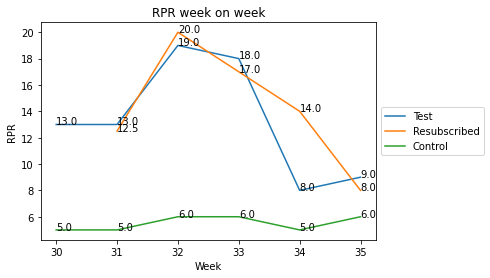

In [298]:
# Median RPR

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in np.sort(df_test['week'].unique()):
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['rides'].median())
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in np.sort(df_test['week'].unique()):
    y_resubscribed.append(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['rides'].median())
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in np.sort(df_control['week'].unique()):
    y_control.append(df_control[df_control['week'] == w]['rides'].median())
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1   

i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1   
    
plt.xlabel("Week")
plt.ylabel("RPR")
plt.title("RPR week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

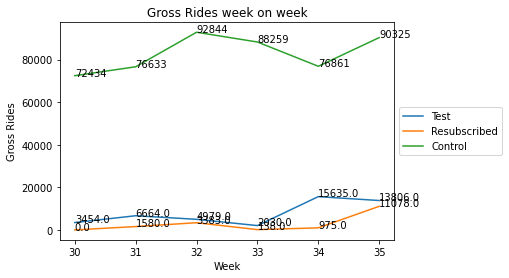

In [299]:
# Gross Rides

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in np.sort(df_test['week'].unique()):
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['rides'].sum())
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in np.sort(df_test['week'].unique()):
    y_resubscribed.append(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['rides'].sum())

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in np.sort(df_control['week'].unique()):
    y_control.append(df_control[df_control['week'] == w]['rides'].sum())
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1
    
i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

plt.xlabel("Week")
plt.ylabel("Gross Rides")
plt.title("Gross Rides week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

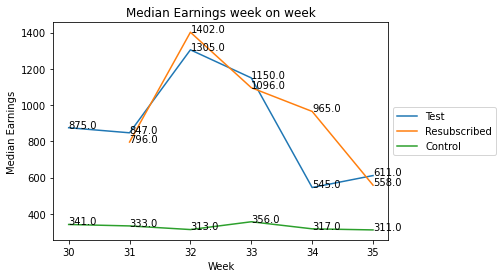

In [300]:
# Median Earnings

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(round(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['orders_earnings'].median(),0))
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(round(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['orders_earnings'].median(),0))

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')
    
y_control = []

for w in df_control['week'].unique():
    y_control.append(round(df_control[df_control['week'] == w]['orders_earnings'].median(),0))
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1
    
i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

plt.xlabel("Week")
plt.ylabel("Median Earnings")
plt.title("Median Earnings week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

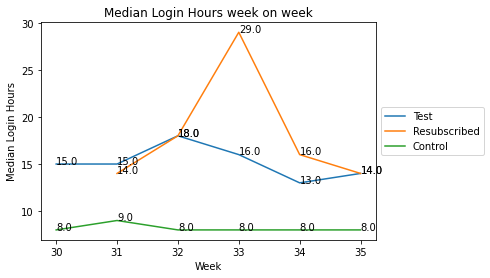

In [301]:
# Median Login hours

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(round(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['login_hours'].median(),0))
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(round(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['login_hours'].median(),0))

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in df_control['week'].unique():
    y_control.append(round(df_control[df_control['week'] == w]['login_hours'].median(),0))
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1    

plt.xlabel("Week")
plt.ylabel("Median Login Hours")
plt.title("Median Login Hours week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

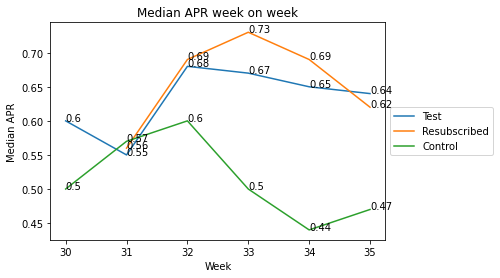

In [302]:
# APR

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(round(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['APR'].median(),2))
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(round(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['APR'].median(),2))

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')


y_control = []

for w in df_control['week'].unique():
    y_control.append(round(df_control[df_control['week'] == w]['APR'].median(),2))
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1    
    
    
plt.xlabel("Week")
plt.ylabel("Median APR")
plt.title("Median APR week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

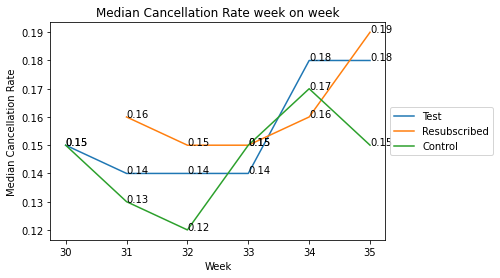

In [303]:
# Cancel Rate

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(round(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['cancel'].median(),2))
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(round(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['cancel'].median(),2))

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in df_control['week'].unique():
    y_control.append(round(df_control[df_control['week'] == w]['cancel'].median(),2))
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1
                                
i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

plt.xlabel("Week")
plt.ylabel("Median Cancellation Rate")
plt.title("Median Cancellation Rate week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

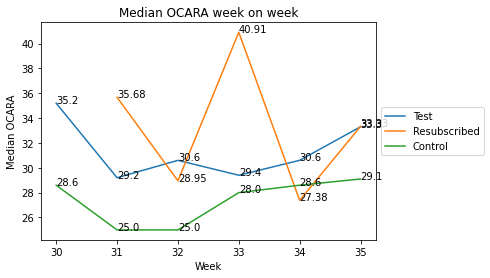

In [304]:
# OCARA

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(round(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['ocara'].median(),1))
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(round(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['ocara'].median(),2))

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in df_control['week'].unique():
    y_control.append(round(df_control[df_control['week'] == w]['ocara'].median(),1))
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1
    
i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

plt.xlabel("Week")
plt.ylabel("Median OCARA")
plt.title("Median OCARA week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

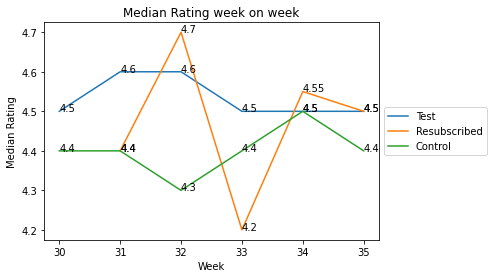

In [305]:
# Median Rating

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['rating'].median())
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['rating'].median())

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in df_control['week'].unique():
    y_control.append(df_control[df_control['week'] == w]['rating'].median())
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1
    
i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

plt.xlabel("Week")
plt.ylabel("Median Rating")
plt.title("Median Rating week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

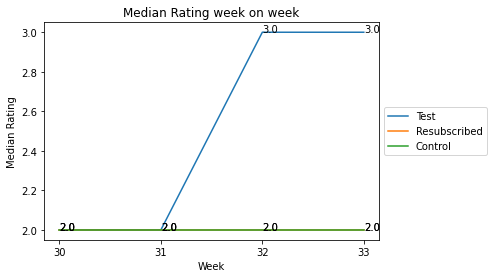

In [206]:
# Median Level

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []

for w in df_test['week'].unique():
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['priority'].median())
    
plt.plot(np.sort(df_test['week'].unique().astype(str)), y_test, label = 'Test')

y_resubscribed = []

for w in df_test['week'].unique():
    y_resubscribed.append(df_test[(df_test['week'] == w) & (df_test['resubscribed'] == 'Yes')]['priority'].median())

plt.plot(np.sort(df_test['week'].unique().astype(str)), y_resubscribed, label = 'Resubscribed')

y_control = []

for w in df_control['week'].unique():
    y_control.append(df_control[df_control['week'] == w]['priority'].median())
    
plt.plot(np.sort(df_control['week'].unique().astype(str)), y_control, label = 'Control')

i = 0
for j in y_test:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

i = 0
for j in y_control:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1
    
i = 0
for j in y_resubscribed:
    ax.annotate(str(j), xy=(i, j))
    i = i + 1

plt.xlabel("Week")
plt.ylabel("Median Rating")
plt.title("Median Rating week on week")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

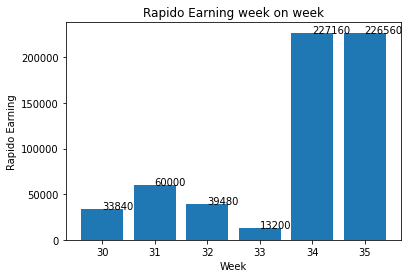

In [306]:
# Rapido Earning from Subscription

fig = plt.figure()
ax = fig.add_subplot(111)

y = []

for w in df_test['week'].unique():
    y.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['captainid'].nunique()*120)
    
plt.bar(np.sort(df_test['week'].unique().astype(str)), y, label = 'Test')

plt.xlabel("Week")
plt.ylabel("Rapido Earning")
plt.title("Rapido Earning week on week")
#plt.legend(loc="best")

for i in range(len(np.sort(df_test['week'].unique()))):
    plt.text(i,y[i],y[i])
    
plt.show()

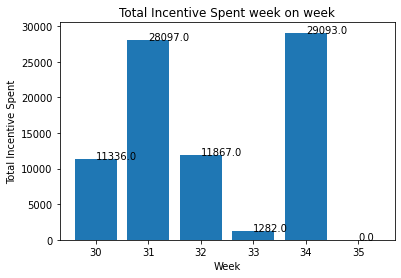

In [307]:
# Incentive Spent for Subscription Captains

y = []

for w in df_test['week'].unique():
    y.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['total_incentive'].sum())
    
plt.bar(np.sort(df_test['week'].unique().astype(str)), y, label = 'Test')

plt.xlabel("Week")
plt.ylabel("Total Incentive Spent")
plt.title("Total Incentive Spent week on week")
#plt.legend(loc="best")

for i in range(len(np.sort(df_test['week'].unique()))):
    plt.text(i,y[i],y[i])
    
plt.show()

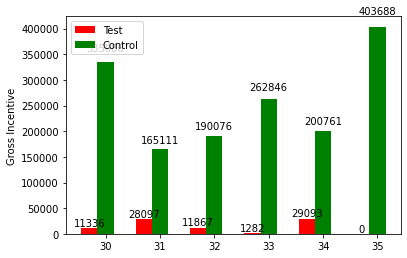

In [310]:
# Gross Incentive paid to captains

N = 6
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []
for w in df_test['week'].unique():
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['total_incentive'].sum())
    
rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')

y_control = []
for w in df_control['week'].unique():
    y_control.append(df_control[(df_control['week'] == w)]['total_incentive'].sum())

rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Gross Incentive')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend()

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

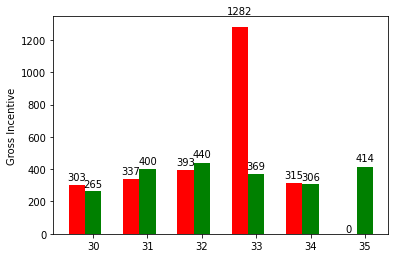

In [316]:
# Median Incentive paid to captains

N = 6
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []
for w in df_test['week'].unique():
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['total_incentive'].median())

y_test = [0 if x != x else x for x in y_test]
    
rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')

y_control = []
for w in df_control['week'].unique():
    y_control.append(df_control[(df_control['week'] == w)]['total_incentive'].median())

rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Gross Incentive')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
#ax.legend()

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

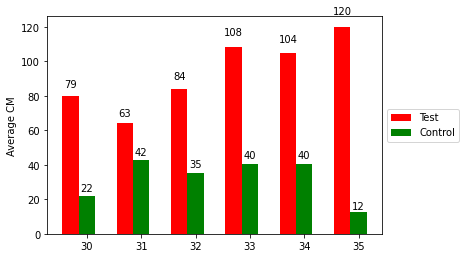

In [318]:
# Mean CM 

N = 6
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []
for w in df_test['week'].unique():
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['cm'].mean())
    
rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')

y_control = []
for w in df_control['week'].unique():
    y_control.append(df_control[(df_control['week'] == w)]['cm'].mean())

rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Average CM')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

In [243]:
for w in df_test['week'].unique():
    df_temp = df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]
    print('Week : ',w, ' GMV : ', round(df_temp['orders_earnings'].sum(),0), ' Subscription Received : ', df_temp['captainid'].nunique()*120, ' Incentive Spent : ',df_temp['total_incentive'].sum(),' Customer Discounts : ',df_temp['discount'].sum(), ' CM % : ', round((df_temp['captainid'].nunique()*120 - df_temp['total_incentive'].sum()) /df_temp['orders_earnings'].sum()*100.0,1))


Week :  30  GMV :  133295.0  Subscription Received :  18120  Incentive Spent :  9438.0  Customer Discounts :  13647.0  CM % :  6.5
Week :  31  GMV :  175842.0  Subscription Received :  22440  Incentive Spent :  16064.0  Customer Discounts :  25110.0  CM % :  3.6
Week :  32  GMV :  123266.0  Subscription Received :  8760  Incentive Spent :  14577.0  Customer Discounts :  15976.0  CM % :  -4.7
Week :  33  GMV :  77529.0  Subscription Received :  8880  Incentive Spent :  7516.0  Customer Discounts :  10892.0  CM % :  1.8


In [252]:
for w in df_control['week'].unique():
    df_temp = df_control[(df_control['week'] == w)]
    print('Week : ',w, ' GMV : ', round(df_temp['orders_earnings'].sum(),0), ' Commission : ', round(df_temp['commission'].sum(),0), ' Incentive Spent : ',df_temp['total_incentive'].sum(),' Customer Discounts : ',df_temp['discount'].sum(), ' CM % : ', round((df_temp['commission'].sum() - df_temp['total_incentive'].sum()) /df_temp['orders_earnings'].sum()*100.0,1))


Week :  30  GMV :  415691.0  Commission :  60421.0  Incentive Spent :  20973.0  Customer Discounts :  50645.0  CM % :  9.5
Week :  32  GMV :  742979.0  Commission :  102238.0  Incentive Spent :  64539.0  Customer Discounts :  97818.0  CM % :  5.1
Week :  33  GMV :  936735.0  Commission :  130130.0  Incentive Spent :  78112.0  Customer Discounts :  129586.0  CM % :  5.6
Week :  31  GMV :  621505.0  Commission :  91380.0  Incentive Spent :  45337.0  Customer Discounts :  90611.0  CM % :  7.4


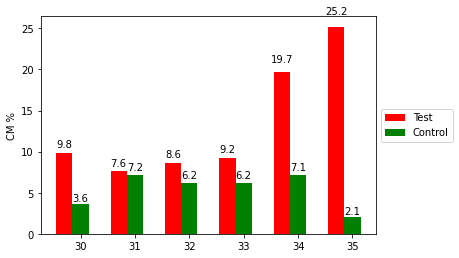

In [319]:
# CM %

N = 6
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []
for w in df_test['week'].unique():
    df_temp = df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]
    y_test.append(round((df_temp['captainid'].nunique()*120 - df_temp['total_incentive'].sum()) /df_temp['orders_earnings'].sum()*100.0,1))
    
rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')

y_control = []
for w in df_control['week'].unique():
    df_temp = df_control[df_control['week'] == w]
    y_control.append(round((df_temp['commission'].sum() - df_temp['total_incentive'].sum()) /df_temp['orders_earnings'].sum()*100.0,1))

rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('CM %')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

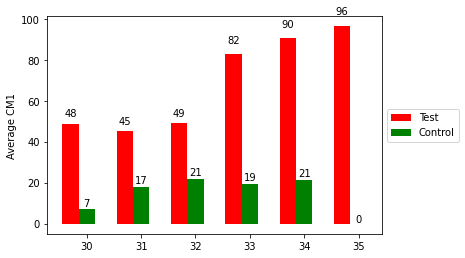

In [320]:
# Mean CM1

N = 6
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

y_test = []
for w in df_test['week'].unique():
    y_test.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['cm1'].mean())
    
rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')

y_control = []
for w in df_control['week'].unique():
    y_control.append(df_control[(df_control['week'] == w)]['cm1'].mean())

rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Average CM1')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

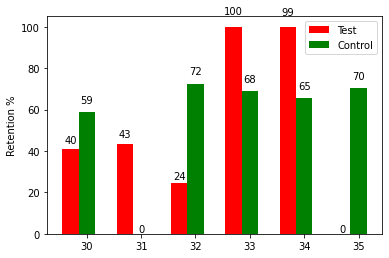

In [321]:
# Retention WoW for captains who subscribed and came to platform again and subscribed again

test_retention = df_test.copy()

y_test =[]
for w in test_retention['week'].unique():
    df_base = test_retention[(test_retention['week']==w) & (test_retention['interested']=='Yes')]
    df_next_week = test_retention[(test_retention['week']==w+1) & (test_retention['interested']=='Yes')]
    df_repeat = df_base.merge(df_next_week, how = 'inner', on = 'captainid')
    retention = df_repeat['captainid'].nunique() * 100.00 / df_base['captainid'].nunique()
    y_test.append(retention)
    

control_retention = df_control.copy()
y_control =[]
for w in control_retention['week'].unique():
    df_base = control_retention[(control_retention['week']==w)]
    df_next_week = control_retention[(control_retention['week']==w+1)]
    df_repeat = df_base.merge(df_next_week, how = 'inner', on = 'rider')
    retention = df_repeat['rider'].nunique() * 100.00 / df_base['rider'].nunique()
    y_control.append(retention)
    
N = 6
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')
rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Retention %')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend()

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

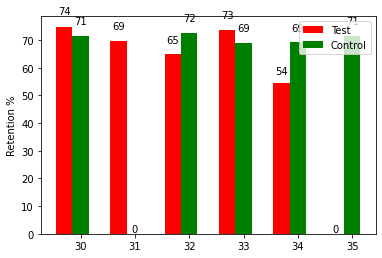

In [322]:
# Retention WoW for captains who subscribed and came to platform again but not subscribed

test_retention = df_test.copy()
df_temp = final_data.copy()

y_test =[]
for w in test_retention['week'].unique():
    df_base = test_retention[(test_retention['week']==w) & (test_retention['interested']=='Yes')]
    df_next_week = df_temp[df_temp['week']==w+1]
    df_repeat = df_base.merge(df_next_week, how = 'inner', left_on = 'captainid', right_on = 'rider')
    retention = df_repeat['captainid'].nunique() * 100.00 / df_base['captainid'].nunique()
    y_test.append(retention)
    

control_retention = df_control.copy()
df_temp = final_data.copy()

y_control =[]
for w in control_retention['week'].unique():
    df_base = control_retention[(control_retention['week']==w)]
    df_next_week = df_temp[df_temp['week']==w+1]['rider']
    df_repeat = df_base.merge(df_next_week, how = 'inner', on = 'rider')
    retention = df_repeat['rider'].nunique() * 100.00 / df_base['rider'].nunique()
    y_control.append(retention)
    
N = 6
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, y_test, width, color='r', label = 'Test')
rects2 = ax.bar(ind+width, y_control, width, color='g',label = 'Control')

ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
ax.set_ylabel('Retention %')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend()

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

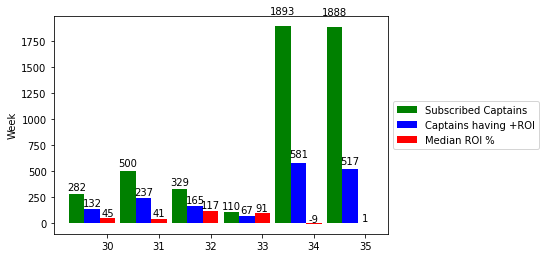

In [349]:
# ROI %

N = 6
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

y_interested_captains = []
for w in np.sort(df_test['week'].unique()):
    y_interested_captains.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['captainid'].nunique())

rects1 = ax.bar(ind-width, y_interested_captains, width, color='g',label = 'Subscribed Captains')

y_positive_roi = []
for w in np.sort(df_control['week'].unique()):
    y_positive_roi.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes') & (df_test['roi'] > 0)]['captainid'].nunique())

rects2 = ax.bar(ind, y_positive_roi, width, color='b',label = 'Captains having +ROI')

y_roi = []
for w in np.sort(df_test['week'].unique()):
    y_roi.append(df_test[(df_test['week'] == w) & (df_test['interested'] == 'Yes')]['roi'].median())
    
rects3 = ax.bar(ind+width, y_roi, width, color='r', label = 'Median ROI %')





ax.set_xticklabels(np.sort(df_test['week'].unique()))
ax.set_ylabel('Week')
#ax.set_ylabel('Gross Incentive')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.show()

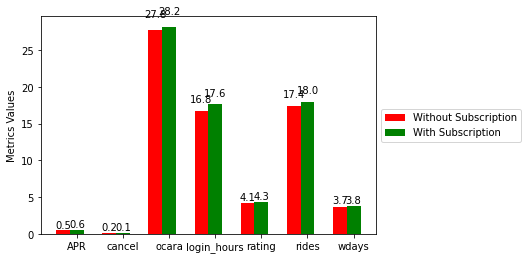

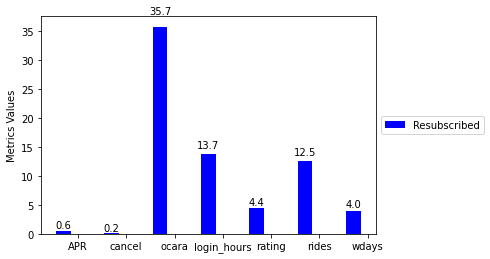

In [350]:
# Captains subscribe in w31 but not in week 30

df_31 = df_test[(df_test['week']==31)&(df_test['interested']=='Yes')]
df_30 = df_test[(df_test['week']==30)&(df_test['interested']=='Yes')]
df_captains = df_31.merge(df_30, how = 'outer', on = 'captainid', indicator=True)
df_captains = df_captains[df_captains['_merge']== 'left_only']
df_captains = df_captains[['captainid']]

#metrics for w30 and w31

metrics_30 = df_captains.merge(final_data[final_data['week']==30], how = 'left', left_on = 'captainid', right_on = 'rider')
metrics_31 = df_captains.merge(df_31, how = 'left', left_on = 'captainid', right_on = 'captainid')

w30 = []
w31 = []

w30.append(metrics_30['APR'].mean())
w30.append(metrics_30['cancel'].mean())
w30.append(metrics_30['ocara'].mean())
w30.append(metrics_30['login_hours'].mean())
w30.append(metrics_30['rating'].mean())
w30.append(metrics_30['rides'].mean())
w30.append(metrics_30['wdays'].mean())

w31.append(metrics_31['APR'].mean())
w31.append(metrics_31['cancel'].mean())
w31.append(metrics_31['ocara'].mean())
w31.append(metrics_31['login_hours'].mean())
w31.append(metrics_31['rating'].mean())
w31.append(metrics_31['rides'].mean())
w31.append(metrics_31['wdays'].mean())

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, w30, width, color='r', label = 'Without Subscription')
rects2 = ax.bar(ind+width, w31, width, color='g',label = 'With Subscription')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays','tot_incentive'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

df_resubscribed = df_test[(df_test['week']==31)&(df_test['resubscribed']=='Yes')]
w31 = []

w31.append(df_resubscribed['APR'].median())
w31.append(df_resubscribed['cancel'].median())
w31.append(df_resubscribed['ocara'].median())
w31.append(df_resubscribed['login_hours'].median())
w31.append(df_resubscribed['rating'].median())
w31.append(df_resubscribed['rides'].median())
w31.append(df_resubscribed['wdays'].median())


rects1 = ax.bar(ind, w31, width, color='b', label = 'Resubscribed')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays','tot_incentive'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

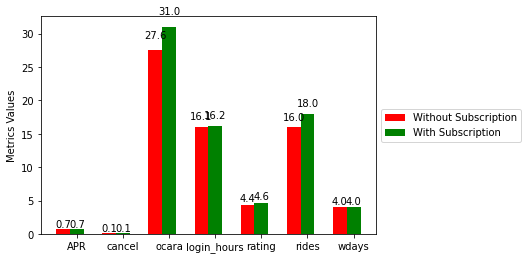

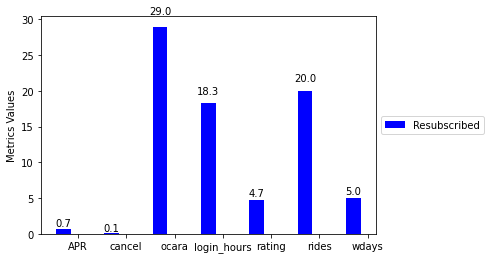

In [333]:
# Captains subscribe in w32 but not in week 31

df_31 = df_test[(df_test['week']==32)&(df_test['interested']=='Yes')]
df_30 = df_test[(df_test['week']==31)&(df_test['interested']=='Yes')]
df_captains = df_31.merge(df_30, how = 'outer', on = 'captainid', indicator=True)
df_captains = df_captains[df_captains['_merge']== 'left_only']
df_captains = df_captains[['captainid']]

#metrics for w30 and w31

metrics_30 = df_captains.merge(final_data[final_data['week']==31], how = 'left', left_on = 'captainid', right_on = 'rider')
metrics_31 = df_captains.merge(df_31, how = 'left', left_on = 'captainid', right_on = 'captainid')

w30 = []
w31 = []

w30.append(metrics_30['APR'].median())
w30.append(metrics_30['cancel'].median())
w30.append(metrics_30['ocara'].median())
w30.append(metrics_30['login_hours'].median())
w30.append(metrics_30['rating'].median())
w30.append(metrics_30['rides'].median())
w30.append(metrics_30['wdays'].median())

w31.append(metrics_31['APR'].median())
w31.append(metrics_31['cancel'].median())
w31.append(metrics_31['ocara'].median())
w31.append(metrics_31['login_hours'].median())
w31.append(metrics_31['rating'].median())
w31.append(metrics_31['rides'].median())
w31.append(metrics_31['wdays'].median())

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, w30, width, color='r', label = 'Without Subscription')
rects2 = ax.bar(ind+width, w31, width, color='g',label = 'With Subscription')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays','tot_incentive'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

df_resubscribed = df_test[(df_test['week']==32)&(df_test['resubscribed']=='Yes')]
w31 = []

w31.append(df_resubscribed['APR'].median())
w31.append(df_resubscribed['cancel'].median())
w31.append(df_resubscribed['ocara'].median())
w31.append(df_resubscribed['login_hours'].median())
w31.append(df_resubscribed['rating'].median())
w31.append(df_resubscribed['rides'].median())
w31.append(df_resubscribed['wdays'].median())


rects1 = ax.bar(ind, w31, width, color='b', label = 'Resubscribed')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays','tot_incentive'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

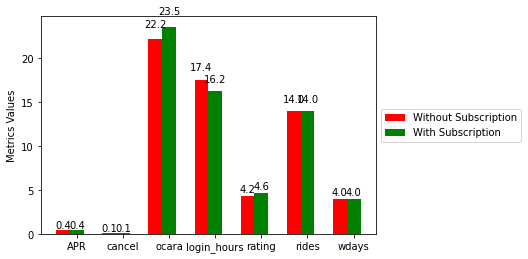

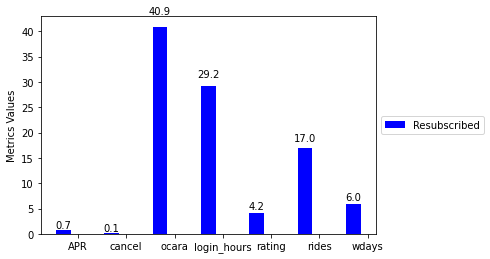

In [335]:
# Captains subscribe in w33 but not in week 32

df_32 = df_test[(df_test['week']==33)&(df_test['interested']=='Yes')]
df_31 = df_test[(df_test['week']==32)&(df_test['interested']=='Yes')]
df_captains = df_32.merge(df_31, how = 'outer', on = 'captainid', indicator=True)
df_captains = df_captains[df_captains['_merge']== 'left_only']
df_captains = df_captains[['captainid']]

#metrics for w31 and w32

metrics_31 = df_captains.merge(final_data[final_data['week']==32], how = 'left', left_on = 'captainid', right_on = 'rider')
metrics_32 = df_captains.merge(df_32, how = 'left', left_on = 'captainid', right_on = 'captainid')

w31 = []
w32 = []

w31.append(metrics_31['APR'].median())
w31.append(metrics_31['cancel'].median())
w31.append(metrics_31['ocara'].median())
w31.append(metrics_31['login_hours'].median())
w31.append(metrics_31['rating'].median())
w31.append(metrics_31['rides'].median())
w31.append(metrics_31['wdays'].median())

w32.append(metrics_32['APR'].median())
w32.append(metrics_32['cancel'].median())
w32.append(metrics_32['ocara'].median())
w32.append(metrics_32['login_hours'].median())
w32.append(metrics_32['rating'].median())
w32.append(metrics_32['rides'].median())
w32.append(metrics_32['wdays'].median())

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, w31, width, color='r', label = 'Without Subscription')
rects2 = ax.bar(ind+width, w32, width, color='g',label = 'With Subscription')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()


N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

df_resubscribed = df_test[(df_test['week']==33)&(df_test['resubscribed']=='Yes')]
w31 = []

w31.append(df_resubscribed['APR'].median())
w31.append(df_resubscribed['cancel'].median())
w31.append(df_resubscribed['ocara'].median())
w31.append(df_resubscribed['login_hours'].median())
w31.append(df_resubscribed['rating'].median())
w31.append(df_resubscribed['rides'].median())
w31.append(df_resubscribed['wdays'].median())


rects1 = ax.bar(ind, w31, width, color='b', label = 'Resubscribed')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays','tot_incentive'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

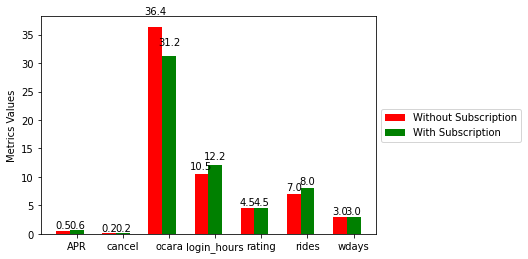

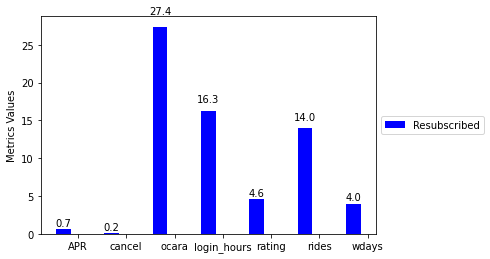

In [336]:
# Captains subscribe in w34 but not in week 33

df_33 = df_test[(df_test['week']==34)&(df_test['interested']=='Yes')]
df_32 = df_test[(df_test['week']==33)&(df_test['interested']=='Yes')]
df_captains = df_33.merge(df_32, how = 'outer', on = 'captainid', indicator=True)
df_captains = df_captains[df_captains['_merge']== 'left_only']
df_captains = df_captains[['captainid']]

#metrics for w32 and w33

metrics_32 = df_captains.merge(final_data[final_data['week']==33], how = 'left', left_on = 'captainid', right_on = 'rider')
metrics_33 = df_captains.merge(df_33, how = 'left', left_on = 'captainid', right_on = 'captainid')

w32 = []
w33 = []

w32.append(metrics_32['APR'].median())
w32.append(metrics_32['cancel'].median())
w32.append(metrics_32['ocara'].median())
w32.append(metrics_32['login_hours'].median())
w32.append(metrics_32['rating'].median())
w32.append(metrics_32['rides'].median())
w32.append(metrics_32['wdays'].median())

w33.append(metrics_33['APR'].median())
w33.append(metrics_33['cancel'].median())
w33.append(metrics_33['ocara'].median())
w33.append(metrics_33['login_hours'].median())
w33.append(metrics_33['rating'].median())
w33.append(metrics_33['rides'].median())
w33.append(metrics_33['wdays'].median())

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, w32, width, color='r', label = 'Without Subscription')
rects2 = ax.bar(ind+width, w33, width, color='g',label = 'With Subscription')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()


N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

df_resubscribed = df_test[(df_test['week']==34)&(df_test['resubscribed']=='Yes')]
w31 = []

w31.append(df_resubscribed['APR'].median())
w31.append(df_resubscribed['cancel'].median())
w31.append(df_resubscribed['ocara'].median())
w31.append(df_resubscribed['login_hours'].median())
w31.append(df_resubscribed['rating'].median())
w31.append(df_resubscribed['rides'].median())
w31.append(df_resubscribed['wdays'].median())


rects1 = ax.bar(ind, w31, width, color='b', label = 'Resubscribed')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays','tot_incentive'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

In [342]:
df_captains

,captainid


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

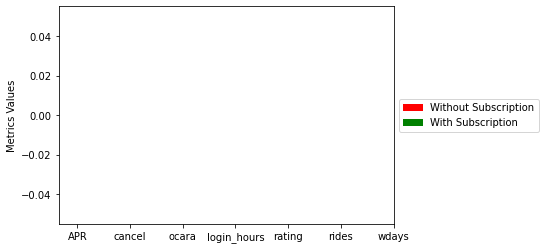

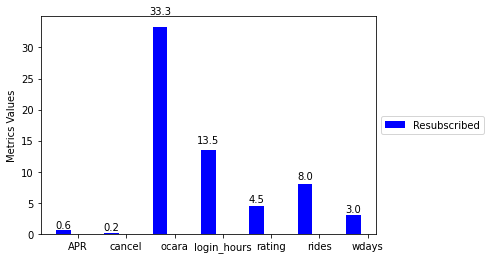

In [337]:
# Captains subscribe in w35 but not in week 34

df_34 = df_test[(df_test['week']==35)&(df_test['interested']=='Yes')]
df_33 = df_test[(df_test['week']==34)&(df_test['interested']=='Yes')]
df_captains = df_34.merge(df_33, how = 'outer', on = 'captainid', indicator=True)
df_captains = df_captains[df_captains['_merge']== 'left_only']
df_captains = df_captains[['captainid']]

#metrics for w32 and w33

metrics_33 = df_captains.merge(final_data[final_data['week']==34], how = 'left', left_on = 'captainid', right_on = 'rider')
metrics_34 = df_captains.merge(df_34, how = 'left', left_on = 'captainid', right_on = 'captainid')

w33 = []
w34 = []

w33.append(metrics_33['APR'].median())
w33.append(metrics_33['cancel'].median())
w33.append(metrics_33['ocara'].median())
w33.append(metrics_33['login_hours'].median())
w33.append(metrics_33['rating'].median())
w33.append(metrics_33['rides'].median())
w33.append(metrics_33['wdays'].median())

w34.append(metrics_34['APR'].median())
w34.append(metrics_34['cancel'].median())
w34.append(metrics_34['ocara'].median())
w34.append(metrics_34['login_hours'].median())
w34.append(metrics_34['rating'].median())
w34.append(metrics_34['rides'].median())
w34.append(metrics_34['wdays'].median())

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, w33, width, color='r', label = 'Without Subscription')
rects2 = ax.bar(ind+width, w34, width, color='g',label = 'With Subscription')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()


N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

df_resubscribed = df_test[(df_test['week']==35)&(df_test['resubscribed']=='Yes')]
w31 = []

w31.append(df_resubscribed['APR'].median())
w31.append(df_resubscribed['cancel'].median())
w31.append(df_resubscribed['ocara'].median())
w31.append(df_resubscribed['login_hours'].median())
w31.append(df_resubscribed['rating'].median())
w31.append(df_resubscribed['rides'].median())
w31.append(df_resubscribed['wdays'].median())


rects1 = ax.bar(ind, w31, width, color='b', label = 'Resubscribed')

ax.set_xticklabels(['APR','cancel','ocara','login_hours','rating','rides','wdays','tot_incentive'])
ax.set_ylabel('Week')
ax.set_ylabel('Metrics Values')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, round(h,1),
                ha='center', va='bottom')

autolabel(rects1)


plt.show()

In [ ]:
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, non_subscription_incentive, width, color='r', label = 'Median Normal Earning')
rects2 = ax.bar(ind+width, subscription_incentive, width, color='g',label = 'Median Earning While Subscriptions')

ax.set_xticklabels([30,31,32,33,34,35])
ax.set_ylabel('Week')
ax.set_ylabel('Earnings')
ax.set_xticks(ind+width)
#ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


plt.show()

In [343]:
# captains interested but not done any rides

total_captains = df_test[(df_test['week']==30) & (df_test['interested']=='Yes')]['captainid'].nunique()
zero_rides = df_test[(df_test['week']==30) & (df_test['interested']=='Yes') & (df_test['rides'].isna())]['captainid'].nunique()
print('Total captains : ', total_captains)
print('captain subscribed but doing 0 rides : ', zero_rides)

Total captains :  282
captain subscribed but doing 0 rides :  70


In [344]:
# Retention WoW for captains who subscribed and came to platform again and subscribed again

test_retention = df_test.copy()

y_test =[]
for w in test_retention['week'].unique():
    df_base = test_retention[(test_retention['week']==w) & (test_retention['interested']=='Yes')]
    tot_captains = df_base['captainid'].nunique()
    median_incentive = df_base['total_incentive'].median()
    incentive_received = df_base['total_incentive'].notna().sum()
    df_next_week = test_retention[(test_retention['week'] > w) & (test_retention['resubscribed']=='Yes')]
    df_repeat = df_base.merge(df_next_week, how = 'inner', on = 'captainid')
    retention = df_repeat['captainid'].nunique() ##* 100.00 / df_base['captainid'].nunique()
    print('Week : ',w, ' Total subscription Captains : ',tot_captains, ' Median Incentive : ', median_incentive, ' Captains Received Incentive : ', incentive_received, ' Incentive Achieved Percent : ', round(incentive_received*100.0/tot_captains,0),'%',' Resubscribed Captains : ', retention)

Week :  30  Total subscription Captains :  282  Median Incentive :  303.0  Captains Received Incentive :  33  Incentive Achieved Percent :  12.0 %  Resubscribed Captains :  162
Week :  31  Total subscription Captains :  500  Median Incentive :  337.0  Captains Received Incentive :  67  Incentive Achieved Percent :  13.0 %  Resubscribed Captains :  187
Week :  32  Total subscription Captains :  329  Median Incentive :  393.0  Captains Received Incentive :  27  Incentive Achieved Percent :  8.0 %  Resubscribed Captains :  20
Week :  33  Total subscription Captains :  110  Median Incentive :  1282.0  Captains Received Incentive :  1  Incentive Achieved Percent :  1.0 %  Resubscribed Captains :  30
Week :  34  Total subscription Captains :  1893  Median Incentive :  315.5  Captains Received Incentive :  80  Incentive Achieved Percent :  4.0 %  Resubscribed Captains :  1694
Week :  35  Total subscription Captains :  1888  Median Incentive :  nan  Captains Received Incentive :  0  Incentive 

In [345]:
# Retention WoW for captains who subscribed and came to platform again and subscribed again

test_retention = df_test.copy()

y_test =[]
for w in test_retention['week'].unique():
    df_base = test_retention[(test_retention['week']==w) & (test_retention['resubscribed']=='Yes')]
    tot_captains = df_base['captainid'].nunique()
    median_incentive = df_base['total_incentive'].median()
    incentive_received = df_base['total_incentive'].notna().sum()
    df_next_week = test_retention[(test_retention['week'] > w) & (test_retention['resubscribed']=='Yes')]
    df_repeat = df_base.merge(df_next_week, how = 'inner', on = 'captainid')
    retention = df_repeat['captainid'].nunique() ##* 100.00 / df_base['captainid'].nunique()
    print('Week : ',w, ' Total subscription Captains : ',tot_captains, ' Median Incentive : ', median_incentive, ' Captains Received Incentive : ', incentive_received, ' Incentive Achieved Percent : ', round(incentive_received*100.0/tot_captains,0),'%',' Resubscribed Captains : ', retention)

Week :  30  Total subscription Captains :  0  Median Incentive :  nan  Captains Received Incentive :  0  Incentive Achieved Percent :  nan %  Resubscribed Captains :  0
Week :  31  Total subscription Captains :  115  Median Incentive :  305.0  Captains Received Incentive :  12  Incentive Achieved Percent :  10.0 %  Resubscribed Captains :  0
Week :  32  Total subscription Captains :  196  Median Incentive :  417.5  Captains Received Incentive :  16  Incentive Achieved Percent :  8.0 %  Resubscribed Captains :  0
Week :  33  Total subscription Captains :  9  Median Incentive :  nan  Captains Received Incentive :  0  Incentive Achieved Percent :  0.0 %  Resubscribed Captains :  0
Week :  34  Total subscription Captains :  79  Median Incentive :  314.0  Captains Received Incentive :  3  Incentive Achieved Percent :  4.0 %  Resubscribed Captains :  0
Week :  35  Total subscription Captains :  1694  Median Incentive :  nan  Captains Received Incentive :  0  Incentive Achieved Percent :  0.0

In [46]:
df_original = df_test.copy()

In [47]:
df_test['week'].unique()

array([30, 31, 32, 33, 34, 35, 36])

In [48]:
df_segment = pd.read_csv('Captain_Segment_Kolkata.csv')
df_segment['week'].unique()

array([36, 35, 34])

In [49]:
df_test = df_test[df_test['week'] == 36]
df_segment = df_segment[df_segment['week'] == 36]

In [50]:
df_test = df_test.merge(df_segment[['RIDER','week','Segment']], how = 'left', left_on = ['captainid','week'], right_on = ['RIDER', 'week'])

In [62]:
df_test.pivot_table(index='Segment', columns = 'week', values = 'login_hours', aggfunc = 'mean').sort_values('Segment')

week,36
Segment,
HP_D_HO,33.032487
HP_D_UHO,41.615256
LP_D_HO,22.180207
LP_D_LO,9.227355
LP_D_MO,13.871537
LP_D_UHO,30.159518
LP_Inter_LO,7.055694
LP_Inter_MO,5.199251
LP_Inter_UHO,6.026578


In [338]:
df_final = final_data[final_data['week'] == 35]

In [339]:
df_final['cm'] = df_final['commission'] - df_final['total_incentive']
df_final['cm1'] = df_final['cm'] - df_final['discount']

In [340]:
df_final = df_final.merge(df_segment[['RIDER','week','Segment']], how = 'left', left_on = ['rider','week'], right_on = ['RIDER', 'week'])

In [53]:
df_control = df_control.merge(df_segment[['RIDER','week','Segment']], how = 'left', left_on = ['rider','week'], right_on = ['RIDER', 'week'])

In [59]:
df_control.pivot_table(index='Segment', columns = 'week', values = 'login_hours', aggfunc = 'mean').sort_values('Segment')

week,36
Segment,
HP_D_HO,27.591201
HP_D_UHO,33.811049
LP_D_HO,18.569808
LP_D_LO,7.987526
LP_D_MO,12.291474
LP_D_UHO,23.474709
LP_Inter_HO,6.781310
LP_Inter_LO,2.607044
LP_Inter_MO,4.652958


In [270]:
df_test.head()

,mobile,week,captainid,wdays,rides,rating,commission,discount,login_hours,orders_earnings,...,ltr,interested,resubscribed,cm,cm1,roi,RIDER_x,Segment_x,RIDER_y,Segment_y
0,9073592154,36,5c1bac9e3f491d0a6e5fda32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Yes,Yes,120.0,120.0,NaN,5c1bac9e3f491d0a6e5fda32,LP_Intra_LO,5c1bac9e3f491d0a6e5fda32,LP_Intra_LO
1,9073617989,36,5ce53fdc25ee3218d4d81e78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Yes,Yes,120.0,120.0,NaN,5ce53fdc25ee3218d4d81e78,LP_D_MO,5ce53fdc25ee3218d4d81e78,LP_D_MO
2,8777087280,36,5c783f9ce1692f4f9bd04b67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Yes,Yes,120.0,120.0,NaN,5c783f9ce1692f4f9bd04b67,LP_Intra_LO,5c783f9ce1692f4f9bd04b67,LP_Intra_LO
3,8910359746,36,5c779cd55e042733c9c03ec9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Yes,Yes,120.0,120.0,NaN,5c779cd55e042733c9c03ec9,LP_D_MO,5c779cd55e042733c9c03ec9,LP_D_MO
4,9088779982,36,5e8859fd7942d7b645399833,2.0,2.0,5.0,0.0,0.0,6.448794,264.12,...,47.0,Yes,Yes,120.0,120.0,-55.98,5e8859fd7942d7b645399833,LP_Intra_MO,5e8859fd7942d7b645399833,LP_Intra_MO


In [31]:
df_test['commission'].sum()

2592.446